# Imports

In [1]:
from glob import glob
import numpy as np
import os
from skimage import io
from skimage.transform import resize
import tensorflow as tf
from keras.applications.xception import preprocess_input as Optimized_preprocess
from keras.applications.vgg16 import VGG16, preprocess_input as VGG16_preprocess
from keras.applications.mobilenet import MobileNet, preprocess_input as MobileNet_preprocess
from keras.applications.resnet50 import ResNet50, preprocess_input as ResNet_preprocess
from keras import layers
from keras.models import Model
from keras.utils import Sequence
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
import imgaug as ia
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import seaborn as sns; sns.set()

Using TensorFlow backend.


# Adquisicion de datos

In [2]:
data_set = ['Train', 'Validation', 'Test']
genders = ['Female', 'Male']

paths = './data/{dataSet}/{gender}*/*.jpg'

partition = {'train':      {'img': [], 'label': []},
             'validation': {'img': [], 'label': []},
             'test':       {'img': [], 'label': []},
             }

for dataSet in data_set:
  for gender in genders:
    for path in glob(paths.format(dataSet=dataSet, gender=gender)):
      partition[dataSet.lower()]['label'].append(gender)
      partition[dataSet.lower()]['img'].append(path)

masks = []
texture = []
for path in glob('./data/masks/*'):
  if os.path.isdir(path):
    for tex in glob(os.path.join(path, '*')):
      texture.append(tex)
  else:
    masks.append(path)

# Muestra los datos de test

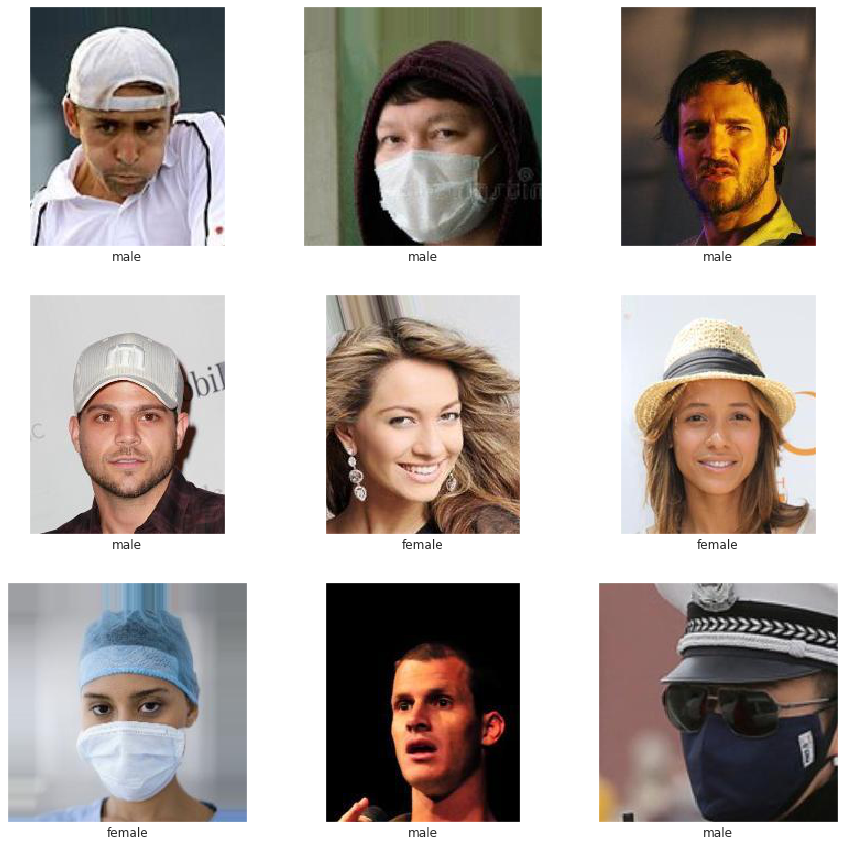

In [12]:
part = partition['test']
id = np.random.choice(list(range(len(part['img']))), 9, False)
decode = {0: 'male', 1: 'female'}

fig, axes = plt.subplots(3, 3, figsize=[15,15])

for path, label, ax in zip(np.array(part['img'])[id], np.array(part['label'])[id], axes.flat):
  # print(label)
  gender = decode[int(label == 'Female')]

  img = io.imread(path)

  ax.imshow(img)
  ax.set_xlabel(f'{gender}')

  # Remove ticks from the plot.
  ax.set_xticks([])
  ax.set_yticks([])

plt.show()

# Generador para el training y validacion

In [3]:
# data augmentation
sometimes = lambda aug: iaa.Sometimes(0.5, aug)

seq_texture = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Flipud(0.5),
      iaa.CropToFixedSize(width=224, height=224),
    ]
  )

seq_imgs = iaa.Sequential(
    [
      sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.15))),
      iaa.Fliplr(0.5),
      iaa.Affine(rotate=(-20, 20)),
    ]
  )

class Generator(Sequence):
  def __init__(self, part, batchSize:int=4, data_set='train', preprocess=None,
               label_encoded=None):
    if data_set == 'train':
      assert label_encoded != None
      assert preprocess != None
    self.part = part
    self.part['img'] = np.array(part['img'])
    self.part['label'] = np.array(part['label'])
    self.data_set = data_set
    self.batch_size = batchSize

    self.on_epoch_end()

    self.label_encoded = label_encoded
    self.preprocess = preprocess

  def on_epoch_end(self):
    List = np.array(list(range(int(len(self.part['img'])))))
    np.random.shuffle(List)
    out_list = []
    l = []
    for lis in List:
      if len(l) == self.batch_size:
        out_list.append(l)
        l = []
      l.append(lis)
    if len(l) > 0:
      out_list.append(l)
    self.list = np.array(out_list)

  def __len__(self):
    return len(self.list)

  def __getitem__(self, index):
    id = self.list[index]

    imgs = []
    labels = {'gender': [], 'mask': []}
    # labels = []
    for path, label in zip(self.part['img'][id], self.part['label'][id]):
      # print(label)
      gender = int(label == 'Female')

      img = io.imread(path)

      mask = 0
      if np.random.randint(2):
        mask = 1
        if np.random.randint(2):
          #texture
          im_tex = io.imread(np.random.choice(texture))
          im_tex = seq_texture(image=im_tex)
          im_tex = resize(im_tex, [224,224]) * 255
          im_form = io.imread(np.random.choice(masks))

          img_mask = np.zeros_like(im_form)
          img_mask_wo_transparency = (np.float32(im_form[..., -1:]) / 255) * np.float32(im_tex)
          img_mask[:,:,:3] = img_mask_wo_transparency
          img_mask[...,-1] = im_form[..., -1]

        else:
          img_mask = io.imread(np.random.choice(masks))

        img = img * (1 - img_mask[:,:,-1:]/255) + img_mask[...,:3] * (img_mask[:,:,-1:]/255)

      img = np.uint8(img)
      img = np.uint8(resize(img, (224, 224)) * 255)
      imgs.append(img)
      labels['gender'].append(gender)
      labels['mask'].append(mask)
    imgs = np.array(imgs)
    if self.data_set == 'train':
      imgs = seq_imgs(images=imgs)
    labels['gender'] = np.array(labels['gender'])
    labels['mask'] = np.array(labels['mask'])
    if self.data_set == 'train':
      imgs = self.preprocess(imgs)
      labels['gender'] = self.label_encoded(labels['gender'])
      labels['mask']   = self.label_encoded(labels['mask'])
    return imgs, labels

# Definicion de modelos

In [4]:
function_none = lambda x: x
function_one_hot = lambda x: to_categorical(x, 2)
function_inverse_one_hot = lambda x: np.argmax(x, axis=-1)
inverse_functions = {function_none: function_none,
                    function_one_hot: function_inverse_one_hot}

def model_optimized():
  inputs = layers.Input((224, 224, 3))
  x = layers.ZeroPadding2D(padding=((0, 1), (0, 1)), name='conv1_pad')(inputs)
  x = layers.Conv2D(32, (3, 3), padding='valid', use_bias=False, strides=(2, 2), name='conv1')(x)
  x = layers.BatchNormalization(name='conv1_bn')(x)
  x = layers.ReLU(10., name='conv1_relu')(x)

  id = 0
  id += 1
  x = layers.SeparableConv2D(64, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(128, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(128, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(256, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(256, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)


  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  mask = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(512, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(mask)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(1024, (3, 3), padding='valid',
                             strides=(2, 2), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  x = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  id += 1
  x = layers.SeparableConv2D(1024, (3, 3), padding='same',
                             strides=(1, 1), use_bias=False,
                             name='conv_dw_{}'.format(id))(x)
  x = layers.BatchNormalization(name='conv_dw_{}_bn'.format(id))(x)
  gender = layers.ReLU(10., name='conv_dw_{}_relu'.format(id))(x)

  mask = layers.GlobalAvgPool2D()(mask)
  gender = layers.GlobalAvgPool2D()(gender)

  mask = layers.Dropout(0.3)(mask)
  gender = layers.Dropout(0.3)(gender)

  mask = layers.Dense(1, activation='sigmoid', name='mask')(mask)
  gender = layers.Dense(1, activation='sigmoid', name='gender')(gender)

  model = Model(inputs=inputs, outputs=[gender, mask], name='optimized')

  model.compile('adam', {'gender': 'binary_crossentropy',
                         'mask': 'binary_crossentropy'},
                metrics=['acc'])

  return model, Optimized_preprocess, function_none

def model_VGG16():
  inputs = layers.Input((224, 224, 3))
  vgg16 = VGG16(include_top=False, weights="imagenet", input_tensor=inputs, pooling='avg')
  vgg16.trainable = False

  x = layers.Dropout(0.3)(vgg16.outputs[0])
  x = layers.Dense(512, 'relu')(x)

  gender = layers.Dense(2, activation='softmax', name='gender')(x)
  mask = layers.Dense(2, activation='softmax', name='mask')(x)

  model = Model(inputs, outputs=[gender, mask], name='vgg10006')

  model.compile('adam', {'gender': 'categorical_crossentropy',
                         'mask': 'categorical_crossentropy'},
                metrics=['acc'])

  return model, VGG16_preprocess, function_one_hot

def model_MobileNet():
  inputs = layers.Input((224, 224, 3))
  mobilenet = MobileNet(include_top=False, weights="imagenet", input_tensor=inputs, pooling='avg')
  mobilenet.trainable = False

  x = layers.Dropout(0.3)(mobilenet.outputs[0])
  x = layers.Dense(1024, 'relu')(x)

  gender = layers.Dense(1, activation='sigmoid', name='gender')(x)
  mask = layers.Dense(1, activation='sigmoid', name='mask')(x)

  model = Model(inputs, outputs=[gender, mask], name='mobilenet')

  model.compile('adam', {'gender': 'mse',
                         'mask': 'mse'},
                metrics=['acc'])

  return model, MobileNet_preprocess, function_none

def model_ResNet():
  inputs = layers.Input((224, 224, 3))
  resnet = ResNet50(include_top=False, weights="imagenet", input_tensor=inputs, pooling='avg')
  resnet.trainable = False

  x = layers.Dropout(0.3)(resnet.outputs[0])
  x = layers.Dense(1024, 'relu')(x)

  gender = layers.Dense(1, activation='sigmoid', name='gender')(x)
  mask = layers.Dense(1, activation='sigmoid', name='mask')(x)

  model = Model(inputs, outputs=[gender, mask], name='resnet')

  model.compile('adam', {'gender': 'binary_crossentropy',
                         'mask': 'binary_crossentropy'},
                metrics=['acc'])

  return model, ResNet_preprocess, function_none


models = {'optimized': model_optimized,
          'vgg16': model_VGG16,
          'mobilenet': model_MobileNet,
          'resnet': model_ResNet}

# Obtencion de los resultados finales

A continuacion se obtienen los nombres de los modelos ya entrenados

In [5]:
models_save = {}
for name_model, model_function in models.items():
    if name_model == 'optimized':
        epochs = [60]
        batchs = [16]
    else:
        epochs = [20, 60, 200]
        batchs = [8, 16, 32]

    for epoch in epochs:
        batch = 16
        filename_best_model = './models/model_{}_E{}_B{}.h5'.format(name_model, epoch, batch)
        models_save['{}_{}_{}'.format(name_model, epoch, batch)] = filename_best_model

## Se define una funcion que muestra los resultados dado un dataset

In [6]:
def test_models(paths, labels, name):
    target_names_gender = ['Female', 'Male']
    target_names_mask = ['Mask', 'no-Mask']
    if type(paths) == np.ndarray:
        imgs_test = paths
        labels_test = labels
    else:
        imgs_test = []
        labels_test = {'gender': [], 'mask': []}
        for path, gender in zip(paths, labels):
            labels_test['gender'].append(int(gender == 'Female'))
            labels_test['mask'].append(int(os.path.dirname(path).endswith('m')))
            imgs_test.append(resize(io.imread(path), [224,224])*255)

        imgs_test = np.array(imgs_test)
        labels_test['gender'] = np.array(labels_test['gender'])
        labels_test['mask'] = np.array(labels_test['mask'])

    for name, path_h5 in models_save.items():
        K.clear_session()
        model_name, epochs, batchs = name.split('_')
        model, preprocess, function_label = models[model_name]()
        model.load_weights(path_h5)

        img_test_for_model = preprocess(np.copy(imgs_test))

        labels_test_for_model = {}
        labels_test_for_model['gender'] = function_label(np.copy(labels_test['gender']))
        labels_test_for_model['mask'] = function_label(np.copy(labels_test['mask']))

        score = model.evaluate(img_test_for_model, labels_test_for_model, verbose=1)

        #Confution Matrix and Classification Report
        Y_pred = model.predict(img_test_for_model)
        Y_pred_gender = inverse_functions[function_label](Y_pred[0])
        Y_pred_mask = inverse_functions[function_label](Y_pred[1])

        print('{} ; Epochs: {} ; Batchs: {}'. format(model_name, epochs, batchs))
        print('{} loss:'.format(name), score[0])
        print('{} loss gender: {}\nTest loss mask: {}'.format(name, score[1], score[2]))
        print('{} accuracy gender: {}\nTest accuracy mask: {}'.format(name, score[3], score[4]))
        print("CNN Error: %.2f%%" % (100-(score[-1] + score[-2])*100/2))
        print('''Confusion Matrix Gender

{}

Confusion Matrix Mask

{}

Classification Report Gender

{}

Classification Report Mask

{}'''.format(
            confusion_matrix(np.round(Y_pred_gender), labels_test['gender']),
            confusion_matrix(np.round(Y_pred_mask), labels_test['mask']),
            classification_report(np.round(Y_pred_gender), labels_test['gender'], target_names=list(set(target_names_gender))),
            classification_report(np.round(Y_pred_mask), labels_test['mask'], target_names=list(set(target_names_mask)))))
        print()

##### Resultados de training

In [7]:
# estatica, no dinamica
# paths, labels = gen_train[0]

# print('Data set Train')
# test_models(paths, labels, 'Train')

for name, path_h5 in models_save.items():
        K.clear_session()
        model_name, epochs, batchs = name.split('_')
        model, preprocess, function_label = models[model_name]()
        model.load_weights(path_h5)

        gen_train   = Generator(partition['train'], batchSize=100, data_set='train', 
                                preprocess=preprocess, label_encoded=function_label)

        score = model.evaluate_generator(gen_train, verbose=1)


        print('{} ; Epochs: {} ; Batchs: {}'. format(model_name, epochs, batchs))
        print('{} loss:'.format(name), score[0])
        print('{} loss gender: {}\nTest loss mask: {}'.format(name, score[1], score[2]))
        print('{} accuracy gender: {}\n{} accuracy mask: {}'.format(name, score[3], name, score[4]))
        print("CNN Error: %.2f%%" % (100-(score[-1] + score[-2])*100/2))
        print()

100/100 [==============================] - 100s 999ms/step - loss: 0.0631 - gender_loss: 0.0599 - mask_loss: 0.0033 - gender_acc: 0.9767 - mask_acc: 0.9989
optimized ; Epochs: 60 ; Batchs: 16
optimized_60_16 loss: 0.06314857700839639
optimized_60_16 loss gender: 0.059877604246139526
Test loss mask: 0.003270967397838831
optimized_60_16 accuracy gender: 0.9767000079154968
Test accuracy mask: 0.9988999962806702
CNN Error: 1.22%

100/100 [==============================] - 116s 1s/step - loss: 0.2753 - gender_loss: 0.2570 - mask_loss: 0.0184 - gender_acc: 0.8961 - mask_acc: 0.9952
vgg16 ; Epochs: 20 ; Batchs: 16
vgg16_20_16 loss: 0.27534853979945184
vgg16_20_16 loss gender: 0.25695857405662537
Test loss mask: 0.018389992415905
vgg16_20_16 accuracy gender: 0.8960999846458435
Test accuracy mask: 0.995199978351593
CNN Error: 5.44%

100/100 [==============================] - 114s 1s/step - loss: 0.2373 - gender_loss: 0.2262 - mask_loss: 0.0111 - gender_acc: 0.9155 - mask_acc: 0.9960
vgg16 ; Epo

/home/mvaldi/anaconda3/lib/python3.7/site-packages/keras_applications/mobilenet.py:207: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


100/100 [==============================] - 120s 1s/step - loss: 0.9945 - gender_loss: 0.5000 - mask_loss: 0.4945 - gender_acc: 0.5000 - mask_acc: 0.5055
mobilenet ; Epochs: 20 ; Batchs: 16
mobilenet_20_16 loss: 0.9944999885559082
mobilenet_20_16 loss gender: 0.5000001192092896
Test loss mask: 0.49449992179870605
mobilenet_20_16 accuracy gender: 0.5
Test accuracy mask: 0.5055000185966492
CNN Error: 49.72%

100/100 [==============================] - 116s 1s/step - loss: 0.1151 - gender_loss: 0.1044 - mask_loss: 0.0107 - gender_acc: 0.8569 - mask_acc: 0.9869
mobilenet ; Epochs: 60 ; Batchs: 16
mobilenet_60_16 loss: 0.1150920020788908
mobilenet_60_16 loss gender: 0.10439354181289673
Test loss mask: 0.010698456317186356
mobilenet_60_16 accuracy gender: 0.8568999767303467
Test accuracy mask: 0.9868999719619751
CNN Error: 7.81%

100/100 [==============================] - 114s 1s/step - loss: 0.1143 - gender_loss: 0.0980 - mask_loss: 0.0163 - gender_acc: 0.8676 - mask_acc: 0.9804
mobilenet ; E

##### Resultados de validation

In [9]:
gen_val   = Generator(partition['validation'],
                  batchSize=len(partition['validation']['img']), data_set='val')
# estatica, no dinamica
paths, labels = gen_val[0]

print('Data set Validation')
test_models(paths, labels, 'Validation')

Data set Validation
1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0831 - gender_loss: 0.0799 - mask_loss: 0.0012 - gender_acc: 0.9760 - mask_acc: 1.0000
optimized ; Epochs: 60 ; Batchs: 16
optimized_60_16 loss: 0.08313552119769156
optimized_60_16 loss gender: 0.0799437090754509
Test loss mask: 0.0012465525651350617
optimized_60_16 accuracy gender: 0.9760000109672546
Test accuracy mask: 1.0
CNN Error: 1.20%
Confusion Matrix Gender

[[490  14]
 [ 10 486]]

Confusion Matrix Mask

[[533   0]
 [  0 467]]

Classification Report Gender

              precision    recall  f1-score   support

        Male       0.98      0.97      0.98       504
      Female       0.97      0.98      0.98       496

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Classification Report Mask

              precision    recall  f1-score   support

     no-Mask       1.00      1

/home/mvaldi/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1000/1000 [==============================] - 2s 2ms/sample - loss: 0.0974 - gender_loss: 0.0839 - mask_loss: 0.0113 - gender_acc: 0.8790 - mask_acc: 0.9860
mobilenet ; Epochs: 60 ; Batchs: 16
mobilenet_60_16 loss: 0.09738541250862182
mobilenet_60_16 loss gender: 0.0839008241891861
Test loss mask: 0.011263525113463402
mobilenet_60_16 accuracy gender: 0.8790000081062317
Test accuracy mask: 0.9860000014305115
CNN Error: 6.75%
Confusion Matrix Gender

[[421  42]
 [ 79 458]]

Confusion Matrix Mask

[[533  14]
 [  0 453]]

Classification Report Gender

              precision    recall  f1-score   support

        Male       0.84      0.91      0.87       463
      Female       0.92      0.85      0.88       537

    accuracy                           0.88      1000
   macro avg       0.88      0.88      0.88      1000
weighted avg       0.88      0.88      0.88      1000


Classification Report Mask

              precision    recall  f1-score   support

     no-Mask       1.00      0.97   

##### Resultados de test

In [11]:
paths =  partition['test']['img']
labels =  partition['test']['label']

print('Data set Test')
test_models(paths, labels, 'Test')

Data set Test
792/792 [==============================] - 2s 2ms/sample - loss: 0.3298 - gender_loss: 0.2818 - mask_loss: 0.0448 - gender_acc: 0.9028 - mask_acc: 0.9861
optimized ; Epochs: 60 ; Batchs: 16
optimized_60_16 loss: 0.3298245887460206
optimized_60_16 loss gender: 0.28176262974739075
Test loss mask: 0.04483463615179062
optimized_60_16 accuracy gender: 0.9027777910232544
Test accuracy mask: 0.9861111044883728
CNN Error: 5.56%
Confusion Matrix Gender

[[353  63]
 [ 14 362]]

Confusion Matrix Mask

[[400  11]
 [  0 381]]

Classification Report Gender

              precision    recall  f1-score   support

        Male       0.96      0.85      0.90       416
      Female       0.85      0.96      0.90       376

    accuracy                           0.90       792
   macro avg       0.91      0.91      0.90       792
weighted avg       0.91      0.90      0.90       792


Classification Report Mask

              precision    recall  f1-score   support

     no-Mask       1.00  

792/792 [==============================] - 4s 5ms/sample - loss: 0.4593 - gender_loss: 0.3935 - mask_loss: 0.0635 - gender_acc: 0.8308 - mask_acc: 0.9811
resnet ; Epochs: 20 ; Batchs: 16
resnet_20_16 loss: 0.45927877648912296
resnet_20_16 loss gender: 0.3935284912586212
Test loss mask: 0.0635041892528534
resnet_20_16 accuracy gender: 0.8308081030845642
Test accuracy mask: 0.9810606241226196
CNN Error: 9.41%
Confusion Matrix Gender

[[296  63]
 [ 71 362]]

Confusion Matrix Mask

[[400  15]
 [  0 377]]

Classification Report Gender

              precision    recall  f1-score   support

        Male       0.81      0.82      0.82       359
      Female       0.85      0.84      0.84       433

    accuracy                           0.83       792
   macro avg       0.83      0.83      0.83       792
weighted avg       0.83      0.83      0.83       792


Classification Report Mask

              precision    recall  f1-score   support

     no-Mask       1.00      0.96      0.98       41